In [ ]:
getwd()
setwd('..')
getwd()

In [2]:
file_name_all=list('facs_Aorta_seurat_tiss.Robj',
'facs_Bladder_seurat_tiss.Robj',
'facs_Brain_Myeloid_seurat_tiss.Robj',
'facs_Brain_Non-Myeloid_seurat_tiss.Robj',
'facs_Diaphragm_seurat_tiss.Robj',
'facs_Fat_seurat_tiss.Robj',
'facs_Heart_seurat_tiss.Robj',
'facs_Kidney_seurat_tiss.Robj',
'facs_Large_Intestine_seurat_tiss.Robj',
'facs_Limb_Muscle_seurat_tiss.Robj',
'facs_Liver_seurat_tiss.Robj',
'facs_Lung_seurat_tiss.Robj',
'facs_Mammary_Gland_seurat_tiss.Robj',
'facs_Marrow_seurat_tiss.Robj',
'facs_Pancreas_seurat_tiss.Robj',
'facs_Skin_seurat_tiss.Robj',
'facs_Spleen_seurat_tiss.Robj',
'facs_Thymus_seurat_tiss.Robj',
'facs_Tongue_seurat_tiss.Robj',
'facs_Trachea_seurat_tiss.Robj')

In [3]:
library(SingleCellExperiment)
library(Seurat)

library(mclust)
library(scran)
library(Matrix)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [3]:
filter_exp <-function(sce,pct){
    expsn <- rowMeans(logcounts(sce))
    keep <- order(expsn, decreasing = TRUE)[seq_len(pct/100*length(expsn))]
    sce_filtered <- sce[keep, ]  
    
    sce_filtered
}

save_sce <- function(sce,path,lowdim='TSNE'){
    
    sizeFactors(sce) <- calculateSumFactors(sce)
    
    save_data <- Matrix(as.matrix(assay(sce,'counts')),sparse=TRUE)
    
    writeMM(save_data,sprintf("%s.data.counts.mm",path))
    write.table(as.matrix(rownames(save_data)),sprintf('%s.data.row',path),row.names=FALSE, col.names=FALSE)
    write.table(as.matrix(colnames(save_data)),sprintf('%s.data.col',path),row.names=FALSE, col.names=FALSE)
    
    tsne_data <- reducedDim(sce, lowdim)
    colnames(tsne_data) <- c(sprintf('%s_1',lowdim),sprintf('%s_2',lowdim))
    print(head(cbind(as.matrix(colData(sce)),tsne_data)))
    write.table(cbind(as.matrix(colData(sce)),tsne_data),sprintf('%s.metadatacol.tsv',path),row.names=TRUE, col.names=TRUE,sep='\t')    
    write.table(cbind(as.matrix(rowData(sce))),sprintf('%s.metadatarow.tsv',path),row.names=TRUE, col.names=TRUE,sep='\t')    
    
    write.table(sizeFactors(sce),file=sprintf('%s.size_factor.tsv',path),sep='\t',row.names=FALSE, col.names=FALSE)    
    
}

save_hvg_seurat <-function(sce,path,method){
    seurat <- CreateSeuratObject(counts = counts(sce), project = "scRNAseq", assay = "RNA",
                                         min.cells = 0, min.features = 0,
                                         meta.data = as.data.frame(colData(sce)))
    #seurat <- ScaleData(seurat, vars.to.regress = "nUMI", display.progress = FALSE)
    seurat <- NormalizeData(seurat)
    seurat <- FindVariableFeatures(seurat, selection.method = method, nfeatures = length(rownames(seurat@assays$RNA)))
    vf <- VariableFeatures(seurat)  
    write.table(vf,file=sprintf('%s.hvg.%s.tsv',path,method),sep='\t',row.names=FALSE, col.names=TRUE)       
}

In [19]:
for(file_name in file_name_all){
    print(file_name)
    path=sprintf('datasets/tabula/%s',file_name)
    path
    load(path)
    new_name=sub('_','',sub('-','',sub('_seurat_tiss.Robj','',sub('facs_','',file_name))))
    
    
    seurat=UpdateSeuratObject(tiss)
    
    seurat@meta.data$phenoid=seurat@meta.data$cell_ontology_class

    seurat=FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000)

    seurat_hvg <- NormalizeData(seurat)

    all.genes <- rownames(seurat_hvg)
    seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

    seurat_hvg_pca = RunPCA(seurat_hvg)

    PC_cluster=50
    PC_2D=50

    #seurat_hvg_pca <- RunTSNE(seurat_hvg_pca, dims= 1:PC_2D)

    seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:PC_cluster)

    seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = 2)    
    
    print(adjustedRandIndex(seurat@meta.data$phenoid, seurat_hvg_pca_label_cluster@meta.data$seurat_clusters))

    
    sce_full_tabula <- as.SingleCellExperiment(seurat_hvg_pca_label_cluster)
    
    sce_full_tabula_expfiltered=filter_exp(sce_full_tabula,30)
    
    
    path=sprintf('datasets/extract/Tabula%s_filtered',new_name)
    
    save_sce(sce_full_tabula_expfiltered, path)

    for(method in c('vst','mvp','disp')){
        save_hvg_seurat(sce_full_tabula_expfiltered, path, method)
    }        

    
}

[1] "facs_Aorta_seurat_tiss.Robj"


Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Col1a2, Serping1, Col6a2, Dcn, Serpinf1, Col6a1, Col3a1, Col1a1, Dpt, Pcolce 
	   Timp2, Mfap5, Htra3, Ogn, C1ra, Loxl1, Islr, Aebp1, Sod3, Gsn 
	   Rcn3, Rarres2, Lrp1, Ccdc80, Olfml3, Fbln1, Clec3b, Olfml2b, Fbn1, C1s 
Negative:  Laptm5, Ctss, Selplg, Sfpi1, Lcp1, Cd52, H2-DMa, H2-Eb1, Tyrobp, Ptprc 
	   Slamf7, Fcer1g, Myo1g, H2-Aa, Plbd1, Fabp4, Cd74, Cytip, Alox5ap, H2-DMb1 
	   Coro1a, Itgb7, Cd68, Pld4, Itgb2, Bcl2a1b, Ly86, Snx20, Cd48, Gpihbp1 
PC_ 2 
Positive:  H2-Eb1, Cd74, Lsp1, H2-Aa, H2-Ab1, Cd52, Lcp1, H2-DMa, Coro1a, Ptprc 
	   Plbd1, Laptm5, Sfpi1, Ctss, Gm2a, Ifi30, H2-DMb1, Pld4, Itgb2, Cd68 
	   Napsa, Tyrobp, Irf5, Ly86, Selplg, Ctsc, Arhgdib, Slamf7, Alox5ap, H2-D

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 408
Number of edges: 14217

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5276
Number of communities: 9
Elapsed time: 0 seconds
[1] 0.471086


Warning message in FUN(...):
“encountered negative size factor estimates”


                         nReads    orig.ident plate.barcode mouse.id tissue
A10.MAA000595.3_9_M.1.1  "1038959" "1"        "4"           "10"     "5"   
A17.B002431.3_39_F.1.1   "2900214" "1"        "2"           "6"      "5"   
A17.MAA000594.3_8_M.1.1  "930992"  "1"        "3"           "9"      "5"   
A17.MAA000906.3_11_M.1.1 "195765"  "1"        "5"           "3"      "5"   
A17.MAA000908.3_10_M.1.1 "635993"  "1"        "6"           "1"      "5"   
A18.B002431.3_39_F.1.1   "1505902" "1"        "2"           "6"      "5"   
                         subtissue FACS.selection mouse.sex
A10.MAA000595.3_9_M.1.1  "3"       "7"            "2"      
A17.B002431.3_39_F.1.1   "3"       "7"            "1"      
A17.MAA000594.3_8_M.1.1  "3"       "7"            "2"      
A17.MAA000906.3_11_M.1.1 "3"       "7"            "2"      
A17.MAA000908.3_10_M.1.1 "3"       "7"            "2"      
A18.B002431.3_39_F.1.1   "3"       "7"            "1"      
                         percent.ercc          f

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Ly6d, Aqp3, Gsta4, Krt18, Krt15, Krt19, Krt8, Cldn7, Sfn, Cldn4 
	   Serinc2, Foxq1, Spint1, Sprr1a, Klf5, Ctse, Tacstd2, Lgals3, Tmprss2, Ivl 
	   Cbr2, Gata3, Ckmt1, Tmprss13, Avpi1, Krt23, 1600029D21Rik, Lypd3, 1190003J15Rik, Upk1a 
Negative:  Serping1, Dcn, Vim, Mxra8, Dkk3, Nbl1, Ecm1, Prelp, Fbln5, Mmp2 
	   Fbln1, Serpinh1, Wnt2, Id3, Cebpd, Serpinf1, Cd81, Fkbp7, Bmp4, Olfml3 
	   Igfbp6, Nupr1, Gadd45g, Cst3, Dpysl2, Serpina3n, Chpf, Thbs2, Hsd11b1, Pdpn 
PC_ 2 
Positive:  Tnc, Car3, Rbp4, Palld, Pde4b, Bmp5, Cpz, Dkk2, 3632451O06Rik, Cxcl14 
	   Tspan13, Gpx3, Spon1, Fam105a, Myl9, Prss35, Gas6, Tgfbi, Pdgfrl, Notum 
	   Chst2, Plk2, Plau, 2010002N04Rik, Moxd1, Ramp1, Srpx2, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1378
Number of edges: 66973

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6260
Number of communities: 11
Elapsed time: 0 seconds
[1] 0.2066694
                        nReads    orig.ident plate.barcode mouse.id tissue
A1.B000610.3_56_F.1.1   "610727"  "1"        "1"           "7"      "1"   
A1.B002764.3_38_F.1.1   "320035"  "1"        "2"           "4"      "1"   
A1.B002771.3_39_F.1.1   "1044981" "1"        "3"           "6"      "1"   
A1.D041914.3_8_M.1.1    "447232"  "1"        "4"           "9"      "1"   
A1.D042253.3_9_M.1.1    "330249"  "1"        "5"           "10"     "1"   
A1.MAA000487.3_10_M.1.1 "748761"  "1"        "6"           "1"      "1"   
                        subtissue FACS.selection mouse.sex
A1.B000610.3_56_F.1.1   "1"       "5"            "1"      
A1.B002764.3_38_F.1.1   "1"       "5"            "1"      
A1.B002771.3_39_F.1.1   "1"       "5"  

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Cd74, Plbd1, H2-Ab1, H2-Aa, H2-Eb1, Ifitm3, Fxyd5, Cybb, Crip1, Lgals3 
	   S100a6, Vim, Anxa2, Ahnak, S100a11, Napsa, Ccr2, Clec12a, Emb, Ccdc109b 
	   Itgb7, Alcam, Mgl2, Cd44, Cd97, Cfp, Olfm1, S100a4, Mrc1, Ccnd2 
Negative:  Csf1r, Slc46a1, Tmem204, Fcrl1, Klhdc8b, Phgdh, Abhd15, Rapgef5, Gcn1l1, Gimap6 
	   Rhobtb1, Tspan9, Serpinf1, Gprasp1, Liph, C1rl, Mpi, Slc5a10, Th1l, Ipo13 
	   Tmem8c, Exog, E330033B04Rik, Zfp866, Engase, Inpp4b, Tbc1d17, Wwc2, Abtb1, Lcmt2 
PC_ 2 
Positive:  H2-Ab1, Sdc4, H2-Eb1, Plbd1, H2-Aa, Cd74, Vim, Crip1, H2-DMb1, Gsn 
	   E330033B04Rik, Anxa2, S100a6, Mgl2, Apoe, Napsa, Clec4b1, Ccr2, Emb, Olfm1 
	   S100a4, Gas7, Cd209a, Itgb7, S100a11, Alcam, Ahna

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4455
Number of edges: 251444

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2842
Number of communities: 17
Elapsed time: 0 seconds


2 singletons identified. 15 final clusters.



[1] 0.009563641
                       nReads   orig.ident plate.barcode mouse.id tissue
A1.B000826.3_39_F.1.1  "680300" "1"        "2"           "6"      "2"   
A1.B001176.3_56_F.1.1  "989907" "1"        "3"           "7"      "2"   
A1.B003279.3_38_F.1.1  "670715" "1"        "6"           "4"      "2"   
A1.B003281.3_39_F.1.1  "719168" "1"        "7"           "6"      "2"   
A1.B003292.3_39_F.1.1  "737609" "1"        "8"           "6"      "2"   
A1.MAA000570.3_8_M.1.1 "437103" "1"        "9"           "9"      "2"   
                       subtissue FACS.selection mouse.sex percent.ercc        
A1.B000826.3_39_F.1.1  "7"       "4"            "1"       "0.051022699849486" 
A1.B001176.3_56_F.1.1  "32"      "4"            "1"       "0.0280173323736967"
A1.B003279.3_38_F.1.1  "6"       "4"            "1"       "0.0536141620291458"
A1.B003281.3_39_F.1.1  "20"      "4"            "1"       "0.0346543890145439"
A1.B003292.3_39_F.1.1  "32"      "4"            "1"       "0.0443956744403577"

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Tspan7, Gpm6a, Ldhb, Ntrk2, Cspg5, Gpr37l1, Slc6a1, Clu, Nrxn1, Bcan 
	   Scg3, Ttyh1, Mmd2, Ptprz1, Aldoc, Slc1a2, Dclk1, Luzp2, Slc1a3, Ppap2b 
	   Pla2g7, Lsamp, Ncan, Cpe, Ntsr2, Gstm5, Kcnk1, Ndrg2, Ednrb, Ramp1 
Negative:  Esam, Hspb1, Cldn5, Ly6c1, Flt1, Ly6a, Igfbp7, Klf2, Itm2a, Pltp 
	   Eng, Wfdc1, Pglyrp1, Cdkn1a, Slc9a3r2, Ifitm3, Slco1a4, Cd34, Ly6e, Gpr116 
	   Apold1, Eltd1, Lsr, Ptprb, Slc2a1, Vwa1, Tmem204, Acvrl1, Cxcl12, Abcg2 
PC_ 2 
Positive:  Mag, Mbp, Tspan2, Ugt8a, Ptgds, Abca2, Ptprd, Prr18, Gsn, Nfasc 
	   Pacs2, Ppp1r16b, Bcas1, Sirt2, Sema4d, Fgfr2, Ralgds, Dip2a, Itgb4, Spock1 
	   Hcn2, Eml1, Rffl, Nacad, Plekha1, Ephb1, Cyp2j12, Kif1a, Stxbp3a, Rftn1 
Ne

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3401
Number of edges: 157807

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7223
Number of communities: 25
Elapsed time: 0 seconds
[1] 0.2950123


Warning message in FUN(...):
“encountered negative size factor estimates”
Warning message in FUN(...):
“encountered negative size factor estimates”


                        nReads    orig.ident plate.barcode mouse.id tissue
A1.B003290.3_38_F.1.1   "379874"  "1"        "7"           "4"      "3"   
A1.B003728.3_56_F.1.1   "709088"  "1"        "8"           "7"      "3"   
A1.MAA000560.3_10_M.1.1 "1586217" "1"        "13"          "1"      "3"   
A1.MAA000564.3_10_M.1.1 "357412"  "1"        "16"          "1"      "3"   
A1.MAA000923.3_9_M.1.1  "279280"  "1"        "23"          "10"     "3"   
A1.MAA000930.3_8_M.1.1  "524865"  "1"        "28"          "9"      "3"   
                        subtissue FACS.selection mouse.sex
A1.B003290.3_38_F.1.1   "32"      "6"            "1"      
A1.B003728.3_56_F.1.1   "32"      "6"            "1"      
A1.MAA000560.3_10_M.1.1 "7"       "6"            "2"      
A1.MAA000564.3_10_M.1.1 "32"      "6"            "2"      
A1.MAA000923.3_9_M.1.1  "20"      "6"            "2"      
A1.MAA000930.3_8_M.1.1  "7"       "6"            "2"      
                        percent.ercc          free_annotation


Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Gsn, Dcn, Lum, Clec3b, Mfap5, Pcolce, Col1a2, Igfbp6, Ccdc80, Serpinf1 
	   Fbln1, Col3a1, Pi16, Islr, Mmp2, Dpt, Col1a1, Htra3, Entpd2, Fstl1 
	   Smoc2, Ifi205, Sparc, Mgp, Sod3, Col6a2, C3, Nid1, Angptl1, Igfbp4 
Negative:  Srgn, Ctss, Cd53, H2-Ab1, Cd74, Arhgdib, Coro1a, H2-Aa, Laptm5, H2-Eb1 
	   Rac2, Cd37, H2-DMa, Cd52, Ly86, Ptprc, Il2rg, Cd79a, Lcp1, H2-DMb2 
	   Cd83, Ly6d, Ppp1r16b, Ms4a1, Ucp2, Cytip, Ptprcap, Napsa, Cd79b, Sh3bgrl3 
PC_ 2 
Positive:  Ctss, H2-Ab1, Cd74, Lsp1, H2-Aa, H2-Eb1, Cd53, Capg, H2-DMa, Laptm5 
	   Ly86, Ctsh, Coro1a, Gsn, Ctsc, Cd37, Cd83, Arhgdib, Dpt, Rac2 
	   Plek, Pld4, Ifi27l2a, Tyrobp, Cd52, Ptprc, Ifi30, Lcp1, Cybb, Cd79a 
Negative:  Flt1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 870
Number of edges: 54529

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4104
Number of communities: 11
Elapsed time: 0 seconds
[1] 0.4644137


Warning message in FUN(...):
“encountered negative size factor estimates”


                       nReads   orig.ident plate.barcode mouse.id tissue
A1.B002762.3_39_F.1.1  "222755" "1"        "1"           "6"      "8"   
A1.D042105.3_11_M.1.1  "400585" "1"        "2"           "3"      "8"   
A10.B002762.3_39_F.1.1 "314030" "1"        "1"           "6"      "8"   
A10.D042105.3_11_M.1.1 "776865" "1"        "2"           "3"      "8"   
A11.B002762.3_39_F.1.1 "202996" "1"        "1"           "6"      "8"   
A11.D042105.3_11_M.1.1 "688058" "1"        "2"           "3"      "8"   
                       subtissue FACS.selection mouse.sex percent.ercc        
A1.B002762.3_39_F.1.1  "8"       "3"            "1"       "0.0727041878278245"
A1.D042105.3_11_M.1.1  "8"       "5"            "2"       "0.0537555924051949"
A10.B002762.3_39_F.1.1 "8"       "3"            "1"       "0.0549690637263163"
A10.D042105.3_11_M.1.1 "8"       "5"            "2"       "0.0515094242870433"
A11.B002762.3_39_F.1.1 "8"       "3"            "1"       "0.0530887175396614"
A11.D042105.3_1

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Coro1a, Rac2, Ctss, Cd74, Tyrobp, Selplg, H2-Ab1, H2-Aa, Cytip, H2-Eb1 
	   H2-DMa, Ptpn6, Alox5ap, Lyz2, Itgb2, Pld4, Ccl6, Cd83, Unc93b1, Cd37 
	   Lsp1, Ctsc, Cd68, Fcgr2b, Cybb, H2-DMb1, Fermt3, Plbd1, Napsa, Lrrc33 
Negative:  Sparc, Col1a2, Col3a1, Col6a1, Dpt, Lum, Cyr61, Col6a2, Igfbp6, Gpx3 
	   Ltbp4, Ccdc80, Col1a1, Sparcl1, Ly6c1, Mmp2, Timp3, Prss23, Bgn, Mfap5 
	   C3, Fbln2, Cxcl12, Fbln1, Fbln5, Fbn1, Gpc3, Gas1, Adamts2, Col4a1 
PC_ 2 
Positive:  Esam, Gpihbp1, Fabp4, Tinagl1, Egfl7, Cd36, Gpr116, Pecam1, Flt1, Cd300lg 
	   8430408G22Rik, Ptprb, Aqp7, Cldn5, Cdh5, Emcn, Eltd1, Kdr, Sdpr, Sox18 
	   Tcf15, Mgll, 1810011O10Rik, Tspan7, Bcam, S1pr1, Ushbp1, F11r, Gpr56, M

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4967
Number of edges: 178223

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8596
Number of communities: 35
Elapsed time: 0 seconds
[1] 0.2045616
                        nReads    orig.ident plate.barcode mouse.id tissue
A1.B000127.3_38_F.1.1   "498539"  "1"        "1"           "4"      "4"   
A1.B002314.3_56_F.1.1   "1112378" "1"        "4"           "7"      "4"   
A1.D045058.3_39_F.1.1   "942024"  "1"        "10"          "6"      "4"   
A1.D045067.3_38_F.1.1   "1137128" "1"        "12"          "4"      "4"   
A1.MAA000388.3_11_M.1.1 "1135641" "1"        "15"          "3"      "4"   
A1.MAA000510.3_8_M.1.1  "1333598" "1"        "19"          "9"      "4"   
                        subtissue FACS.selection mouse.sex percent.ercc        
A1.B000127.3_38_F.1.1   "31"      "5"            "1"       "0.0647495375703024"
A1.B002314.3_56_F.1.1   "26"      "5"            "1"   

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Lyz2, Ctss, Tyrobp, Fcer1g, Laptm5, Csf1r, C1qb, Fcgr3, C1qc, C1qa 
	   Ly86, Cd68, Alox5ap, Ctsc, Pld4, Sfpi1, Lcp1, Cd14, Cd53, C5ar1 
	   Cybb, Emr1, Coro1a, Cd74, Mrc1, Ccl6, Ms4a6c, Ptpn6, Pf4, H2-DMa 
Negative:  Tm4sf1, Ccdc80, Mgp, Bgn, Cxcl12, Fbln1, Ly6a, Col1a2, Sdpr, Htra3 
	   Col3a1, Tsc22d1, Nid1, Mmp2, Gpx3, Fbln2, Gas1, Cav1, Lpl, Jam2 
	   Dpep1, Eng, Col6a1, Mfap5, Crispld2, Fbln5, Col6a2, Slc9a3r2, Col1a1, Islr 
PC_ 2 
Positive:  Fbln1, Htra3, Ccdc80, Bgn, Mgp, Col1a2, Col3a1, Mmp2, Gpx3, Dpep1 
	   Mfap5, Crispld2, Gas1, Col1a1, Islr, Col6a1, Ecm1, Ogn, Col6a2, Entpd2 
	   Clec3b, Pcolce2, Olfml3, Igf1, Smoc2, Matn2, C1s, Axl, Fbln5, Adamts2 
Negative:  Cd36, Fabp4,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4365
Number of edges: 163781

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7733
Number of communities: 27
Elapsed time: 0 seconds
[1] 0.2160545


Warning message in FUN(...):
“encountered negative size factor estimates”
Warning message in FUN(...):
“encountered negative size factor estimates”


                      nReads    orig.ident plate.barcode mouse.id tissue
A1.B000412.3_56_F.1.1 "755516"  "1"        "1"           "7"      "5"   
A1.B000633.3_56_F.1.1 "827219"  "1"        "2"           "7"      "5"   
A1.B000634.3_56_F.1.1 "97253"   "1"        "3"           "7"      "5"   
A1.B002423.3_39_F.1.1 "1058215" "1"        "8"           "6"      "5"   
A1.B002427.3_39_F.1.1 "502868"  "1"        "9"           "6"      "5"   
A1.B002428.3_38_F.1.1 "411644"  "1"        "10"          "4"      "5"   
                      subtissue FACS.selection mouse.sex percent.ercc        
A1.B000412.3_56_F.1.1 "29"      "7"            "1"       "0.0774858817424219"
A1.B000633.3_56_F.1.1 "30"      "7"            "1"       "0.0231292918676673"
A1.B000634.3_56_F.1.1 "22"      "7"            "1"       "0.207540558819455" 
A1.B002423.3_39_F.1.1 "30"      "7"            "1"       "0.0305755543972055"
A1.B002427.3_39_F.1.1 "22"      "7"            "1"       "0.0439571930211468"
A1.B002428.3_38_F.1.1

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Aldob, Gpx3, Miox, Slc34a1, Acsm2, Akr1c21, Fbp1, Pck1, Keg1, Slc27a2 
	   Cyp2j5, Pdzk1, Ugt3a2, Dnase1, Acy3, Slc4a4, Glyat, Aldh6a1, Cml1, Car2 
	   Khk, Slc22a8, Ugt2b38, Slc22a18, Idh1, Slc22a12, Spp1, Slc17a1, Aldh8a1, Slc22a6 
Negative:  Tmsb4x, Nrp1, Psmb8, Cst3, Eng, Actb, Ppap2a, Cdkn1a, Btg2, Emcn 
	   Ly6c1, H2-Ab1, Myadm, Ccnd2, Nfkbia, Dusp1, Sparc, Flt1, Arpc1b, Ppap2b 
	   Unc93b1, Cd74, Rsad2, Cd200, Lgals9, Slc9a3r2, Plvap, Egfl7, H2-Aa, Irf1 
PC_ 2 
Positive:  Ctss, Tyrobp, Laptm5, Lcp1, C1qb, C1qa, C1qc, Fcer1g, Csf1r, Cd68 
	   Lyz2, Ly86, H2-Eb1, Fcgr3, Cd52, Pld4, Cybb, Coro1a, Plbd1, Ptprc 
	   Mpeg1, H2-Aa, Cx3cr1, Slamf9, Cd72, H2-DMa, Emr1, Cd74, Lilra5, Cd53

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 519
Number of edges: 20043

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5591
Number of communities: 8
Elapsed time: 0 seconds
[1] 0.5153693


Warning message in FUN(...):
“encountered negative size factor estimates”


                         nReads    orig.ident plate.barcode mouse.id tissue
A1.B001717.3_38_F.1.1    "951011"  "1"        "1"           "4"      "6"   
A10.B002775.3_39_F.1.1   "1059637" "1"        "2"           "6"      "6"   
A10.MAA000752.3_10_M.1.1 "409127"  "1"        "4"           "1"      "6"   
A11.MAA000801.3_11_M.1.1 "340318"  "1"        "5"           "3"      "6"   
A12.B001717.3_38_F.1.1   "1076045" "1"        "1"           "4"      "6"   
A12.MAA000801.3_11_M.1.1 "495057"  "1"        "5"           "3"      "6"   
                         subtissue FACS.selection mouse.sex
A1.B001717.3_38_F.1.1    "1"       "7"            "1"      
A10.B002775.3_39_F.1.1   "1"       "7"            "1"      
A10.MAA000752.3_10_M.1.1 "1"       "7"            "2"      
A11.MAA000801.3_11_M.1.1 "1"       "7"            "2"      
A12.B001717.3_38_F.1.1   "1"       "7"            "1"      
A12.MAA000801.3_11_M.1.1 "1"       "7"            "2"      
                         percent.ercc         fr

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Agr2, Cd24a, Tspan13, Pdia6, Txndc5, Atp6ap2, Chst4, Pdia5, Slc50a1, Herpud1 
	   Dpysl2, Ly6e, Cd81, St3gal6, Creb3l4, Qsox1, Klk1, Nr4a1, Ssr1, Oit1 
	   Hepacam2, Atp2c2, Hspa5, Ramp1, Slc12a8, Anxa5, Ern2, Rab15, Bace2, Pim3 
Negative:  Cyp2c55, Krt20, 1810065E05Rik, Prss30, Sectm1b, Emp1, Car1, Ces2e, Ces2c, Car4 
	   Ces2a, Mep1a, Cyp3a13, Dpep1, Cdhr2, Tmigd1, Ceacam20, Mxd1, 1110032A04Rik, Slc26a3 
	   Pmp22, Lgals3, Mgat4c, Slc9a2, Mettl7b, Fmo5, Slc13a2, 2610528A11Rik, Fabp2, Aqp8 
PC_ 2 
Positive:  Ramp1, Gm1123, Hpd, Tpsg1, Ccl6, Hgfac, Hepacam2, Spink4, Atp2c2, Spdef 
	   Rep15, Lrrc26, Qsox1, Slc12a8, Gde1, Bcas1, Cgref1, Sval1, Bace2, Rap1gap 
	   Atoh1, Gpr20, Nupr1, Cr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3938
Number of edges: 148254

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7965
Number of communities: 25
Elapsed time: 0 seconds
[1] 0.1635058


Warning message in FUN(...):
“encountered negative size factor estimates”


                        nReads    orig.ident plate.barcode mouse.id tissue
A1.MAA000611.3_8_M.1.1  "1107042" "1"        "2"           "9"      "7"   
A1.MAA000612.3_9_M.1.1  "328769"  "1"        "3"           "10"     "7"   
A1.MAA000870.3_10_M.1.1 "1957713" "1"        "4"           "1"      "7"   
A1.MAA000871.3_11_M.1.1 "515953"  "1"        "5"           "3"      "7"   
A1.MAA000909.3_10_M.1.1 "431942"  "1"        "6"           "1"      "7"   
A1.MAA000937.3_8_M.1.1  "355303"  "1"        "7"           "9"      "7"   
                        subtissue FACS.selection mouse.sex
A1.MAA000611.3_8_M.1.1  "28"      "5"            "2"      
A1.MAA000612.3_9_M.1.1  "28"      "5"            "2"      
A1.MAA000870.3_10_M.1.1 "9"       "5"            "2"      
A1.MAA000871.3_11_M.1.1 "28"      "5"            "2"      
A1.MAA000909.3_10_M.1.1 "28"      "5"            "2"      
A1.MAA000937.3_8_M.1.1  "9"       "5"            "2"      
                        percent.ercc         
A1.MAA000611.3_8

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Srgn, Laptm5, Cd53, Coro1a, Arhgdib, Cd74, Cd52, H2-Ab1, H2-Aa, Rac2 
	   Ctss, H2-Eb1, Il2rg, Cd37, Lcp1, H2-DMa, Ptprc, Cytip, Cd83, Ucp2 
	   Napsa, Tspan13, Ccr7, H2-DMb2, Cd79a, Ly86, H2-Ob, Gimap6, Ptpn6, Cd48 
Negative:  Dcn, Gsn, Pcolce, Clec3b, Col1a2, Igfbp6, Mfap5, Serpinf1, Fstl1, C1s 
	   Col6a2, Lum, Dpep1, Col1a1, Col6a3, Col6a1, Col3a1, Ifi205, Islr, Fbn1 
	   Nid1, Mmp2, Lrrn4cl, Myoc, C1ra, Rnase4, Ogn, Smoc2, Fndc1, Ccdc80 
PC_ 2 
Positive:  Ctss, Laptm5, Cd53, Lyz2, Arhgdib, Tyrobp, H2-Ab1, H2-Aa, Cd74, H2-Eb1 
	   Ctsc, Cd83, Sfpi1, Alox5ap, Lsp1, Coro1a, Fcer1g, Ccl9, Pld4, H2-DMa 
	   Cd52, Cybb, Lilrb4, Cd68, Lcp1, Fcgr3, Plek, Ly86, H2-DMb1, Fcgr2b 
Negative:  

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1090
Number of edges: 48708

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6109
Number of communities: 11
Elapsed time: 0 seconds
[1] 0.4218705


Warning message in FUN(...):
“encountered negative size factor estimates”


                       nReads    orig.ident plate.barcode mouse.id tissue
A1.B002765.3_38_F.1.1  "878318"  "1"        "1"           "4"      "8"   
A1.D042103.3_11_M.1    "774558"  "1"        "3"           "3"      "8"   
A1.D042186.3_8_M.1.1   "914257"  "1"        "5"           "9"      "8"   
A10.B002765.3_38_F.1.1 "1543007" "1"        "1"           "4"      "8"   
A10.B002769.3_39_F.1.1 "2521710" "1"        "2"           "6"      "8"   
A10.D042186.3_8_M.1.1  "732744"  "1"        "5"           "9"      "8"   
                       subtissue FACS.selection mouse.sex percent.ercc        
A1.B002765.3_38_F.1.1  "16"      "3"            "1"       "0.0240152011823142"
A1.D042103.3_11_M.1    "16"      "5"            "2"       "0.0811068600409289"
A1.D042186.3_8_M.1.1   "16"      "5"            "2"       "0.0183181451643211"
A10.B002765.3_38_F.1.1 "16"      "3"            "1"       "0.0321089954491138"
A10.B002769.3_39_F.1.1 "16"      "3"            "1"       "0.0139513386504752"
A10.D042

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Fabp1, Mgst1, Apoc4, Gm2083, Gstm1, Mup3, Scd1, Cyp3a11, Errfi1, Pon1 
	   Nudt7, Aadac, Ugt2b5, Tmem205, Cml1, Hamp, Keg1, Serpina1e, Ces3b, Cyp2c50 
	   Slc22a1, Cyp2c29, Hsd3b3, Ugt2b1, Grhpr, Acad11, Bhmt2, Dmgdh, Dpys, Cyp2e1 
Negative:  Tmsb4x, Actb, Sh3bgrl3, Arhgdib, Ucp2, Pkm2, Laptm5, Cd52, Rac2, Coro1a 
	   Ptprc, Fxyd5, Cd53, Cd97, Iqgap1, Gimap4, Itgb2, Selplg, Cnn2, Il2rg 
	   Lsp1, Crip1, Ly6a, Ptprcap, Ccnd2, Ifi27l2a, Aldoa, Fcer1g, Fermt3, Lcp1 
PC_ 2 
Positive:  Igfbp7, Clec4g, Tinagl1, Eng, Gpihbp1, Cyp4b1, Dnase1l3, F8, Oit3, Sparc 
	   Fcgr2b, Ppap2a, Egfl7, Esam, Plxnc1, Cldn5, Sdpr, Slc43a3, Clec14a, Tm4sf1 
	   Tmem204, Timp3, Jam2, Pde2a, Tek, Cd93, Emilin1, B

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 714
Number of edges: 27175

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6148
Number of communities: 12
Elapsed time: 0 seconds
[1] 0.3581057
                         nReads    orig.ident plate.barcode mouse.id tissue
A1.MAA000907.3_11_M.1.1  "59288"   "1"        "2"           "3"      "9"   
A1.MAA100039.3_11_M.1.1  "1369546" "1"        "3"           "3"      "9"   
A1.MAA100138.3_56_F.1.1  "1838345" "1"        "7"           "7"      "9"   
A1.MAA100140.3_57_F.1.1  "1664289" "1"        "8"           "8"      "9"   
A10.MAA000907.3_11_M.1.1 "306456"  "1"        "2"           "3"      "9"   
A10.MAA100041.3_9_M.1.1  "604966"  "1"        "5"           "10"     "9"   
                         subtissue FACS.selection mouse.sex
A1.MAA000907.3_11_M.1.1  "27"      "7"            "2"      
A1.MAA100039.3_11_M.1.1  "19"      "1"            "2"      
A1.MAA100138.3_56_F.1.1  "19" 

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Coro1a, Laptm5, Arhgdib, Rac2, Tyrobp, Selplg, Fcer1g, Ctss, Lsp1, Itgb2 
	   Sfpi1, Ptpn6, Alox5ap, Cd74, Lyz2, Pld4, Plbd1, Ccl6, Napsa, Cd68 
	   Cybb, H2-DMa, Emb, Cd48, Hck, Ncf2, Itgb7, H2-Ab1, Ms4a6c, Ly86 
Negative:  Serping1, Bgn, Sod3, Gsn, Olfml3, Pcolce2, Ogn, Inmt, Mgp, Pcolce 
	   Mxra8, Dpep1, Gpx3, Col1a2, Crispld2, Nbl1, Sparcl1, Fhl1, Fbln1, Ms4a4d 
	   Col6a1, Mfap4, Col6a2, Adh1, Pdgfra, Mmp2, Dpt, Prelp, Gpc3, Col3a1 
PC_ 2 
Positive:  Dusp1, Coro1a, Laptm5, Lsp1, Arhgdib, Cst3, Tyrobp, Fcer1g, Ctss, Selplg 
	   Gm2a, Itgb2, Rac2, Sfpi1, Alox5ap, Ccl6, Cybb, Pld4, Ifi27l2a, Cd68 
	   Plac8, Ms4a6c, Ncf2, Cd300a, Cd48, Rgs2, Ly86, Junb, Csf1r, Hck 
Negative:  Tmem21

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1716
Number of edges: 65291

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7780
Number of communities: 22
Elapsed time: 0 seconds
[1] 0.3401021
                        nReads    orig.ident plate.barcode mouse.id tissue
A1.MAA000526.3_9_M.1.1  "1956405" "1"        "2"           "10"     "10"  
A1.MAA000530.3_8_M.1.1  "552077"  "1"        "3"           "9"      "10"  
A1.MAA001847.3_39_F.1.1 "78243"   "1"        "6"           "6"      "10"  
A1.MAA001889.3_38_F.1.1 "182800"  "1"        "7"           "4"      "10"  
A1.MAA001892.3_38_F.1.1 "347210"  "1"        "8"           "4"      "10"  
A10.D043522.3_39_F.1.1  "980589"  "1"        "1"           "6"      "10"  
                        subtissue FACS.selection mouse.sex percent.ercc        
A1.MAA000526.3_9_M.1.1  "1"       "5"            "2"       "0.0137705787403679"
A1.MAA000530.3_8_M.1.1  "1"       "5"            "2"    

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Krt8, Tm4sf1, Gata3, Lypd3, Krt18, 1600029D21Rik, Cd24a, Krt17, Hspb1, Krt14 
	   Acta2, Krt5, Tpm2, Gjb4, Tinagl1, Pmepa1, Tagln, Sox4, Pdlim3, Atp1a1 
	   Gjb3, Trf, Cnn1, Kcnk1, Chi3l1, Aqp3, Tacstd2, Alpl, Ralgds, Cldn7 
Negative:  Dpt, Col1a2, Igfbp6, Clec3b, Serping1, Mfap5, Col3a1, Rarres2, Cd34, Col1a1 
	   Lum, Serpinf1, Dpep1, Loxl1, Dcn, Efemp1, Htra3, Nid1, Tnfaip6, Ifi205 
	   Sod3, C1ra, Islr, Col6a3, Fn1, Has1, Cd248, Col6a2, Ogn, Ddr2 
PC_ 2 
Positive:  Krt19, Krt7, Prlr, Cldn4, Cldn3, Cldn7, Gipc2, Tspan1, Tmprss13, Tmem56 
	   Tmc4, Dkkl1, Wfdc2, Lgals3, AW112010, Cxcl15, Aqp5, Clu, Ly6d, Cd82 
	   Wnt4, Vill, Krt18, Slc12a2, Glul, Cgn, Slc44a4, Slc5a5, Areg, Cdo1 
Ne

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2405
Number of edges: 105155

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6873
Number of communities: 17
Elapsed time: 0 seconds
[1] 0.2407074
                       nReads    orig.ident plate.barcode mouse.id tissue
A1.B000167.3_56_F.1.1  "383682"  "1"        "2"           "7"      "11"  
A10.B000166.3_56_F.1.1 "2246909" "1"        "1"           "7"      "11"  
A10.B002433.3_38_F.1.1 "1812385" "1"        "6"           "4"      "11"  
A10.B002435.3_39_F.1.1 "722673"  "1"        "7"           "6"      "11"  
A10.B002436.3_39_F.1.1 "749936"  "1"        "8"           "6"      "11"  
A10.B002438.3_38_F.1.1 "419801"  "1"        "10"          "4"      "11"  
                       subtissue FACS.selection mouse.sex percent.ercc         
A1.B000167.3_56_F.1.1  "25"      "5"            "1"       "0.0129096989966555" 
A10.B000166.3_56_F.1.1 "25"      "5"            "1"       "0.0

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Hp, S100a8, S100a9, Lyz2, S100a11, 1810033B17Rik, 1100001G20Rik, Lcn2, Ifitm6, Pglyrp1 
	   Gsr, Cd177, Anxa1, Mmp9, Pygl, Gda, Itgam, Slpi, Lgals3, Chi3l1 
	   Lrg1, C5ar1, Tyrobp, Hdc, S100a6, Ngp, Retnlg, Mxd1, Trem3, Mmp8 
Negative:  Cd79b, Cnp, Cd79a, Dusp2, Ly6d, Tubb5, Cd19, Chchd10, Spib, Vpreb3 
	   Cd72, Blnk, Pafah1b3, Fcrla, H2-Ab1, Cd74, H2afy, Sdc4, Tnfrsf13c, Blk 
	   H2-Ob, 2010001M09Rik, Ppp1r16b, Smarca4, Ebf1, Siglecg, Faim3, Ms4a1, Hsp90b1, Sod1 
PC_ 2 
Positive:  Cd34, Tmem176b, Gpr56, Ctla2a, Igfbp4, Car2, Tspan4, Stmn1, Eltd1, Angpt1 
	   Rab38, Ifitm1, Fam69b, Kit, Prtn3, Muc13, H2afy, Myc, Mpl, Eng 
	   Tuba1b, Mcm6, Tuba4a, Mpo, Serpina3g, Srm, Nkg7, Ninj1, C3

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5037
Number of edges: 216415

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8044
Number of communities: 27
Elapsed time: 0 seconds
[1] 0.6216044
                        nReads    orig.ident plate.barcode mouse.id tissue
A1.D041912.3_8_M.1.1    "339720"  "1"        "1"           "9"      "12"  
A1.MAA000409.3_10_M.1.1 "470704"  "1"        "8"           "1"      "12"  
A1.MAA000596.3_9_M.1.1  "875292"  "1"        "9"           "10"     "12"  
A1.MAA000600.3_8_M.1.1  "2909396" "1"        "10"          "9"      "12"  
A1.MAA000652.3_10_M.1.1 "136505"  "1"        "12"          "1"      "12"  
A1.MAA000848.3_10_M.1.1 "450644"  "1"        "14"          "1"      "12"  
                        subtissue FACS.selection mouse.sex
A1.D041912.3_8_M.1.1    "18"      "5"            "2"      
A1.MAA000409.3_10_M.1.1 "18"      "5"            "2"      
A1.MAA000596.3_9_M.1.1  "21"      "5" 

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Sparc, Ifitm3, Eng, Sparcl1, Timp3, Col4a2, Ltbp4, Cd34, Slc43a3, Ahnak 
	   Ly6a, Crip2, Tmem204, Prkcdbp, Ppap2b, Nrp1, Mfge8, B2m, Acvrl1, Col4a1 
	   Msn, Epas1, Tm4sf1, Anxa2, Ppap2a, Fbln2, Hspg2, Pltp, Vim, Ptrf 
Negative:  Ttr, 1700086L19Rik, Dbpht2, Tmsb15b2, C8b, Sfrp5, Tmem59l, G6pc2, Rbp4, Pyy 
	   Pappa2, Ucn3, Prss53, Fam151a, Insrr, Calb1, Sez6l, Folr1, Ppy, Gadd45g 
	   Oxtr, Gpx3, Dusp26, Edn3, Ace2, Glp1r, Arg1, Irs2, Slc38a5, Ptprf 
PC_ 2 
Positive:  Flt1, Pecam1, Emcn, Plvap, Kdr, Ptprb, S1pr1, 1190002H23Rik, Egfl7, Cd300lg 
	   Mmrn2, Clec14a, Tmem88, Ly6c1, Fabp4, Eltd1, Gpihbp1, Sox18, Cdh5, Tie1 
	   Robo4, Gimap6, Icam2, Gpr116, Mgll, Cd93, Esam, Thrsp, Arhgap3

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1564
Number of edges: 67618

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7472
Number of communities: 15
Elapsed time: 0 seconds
[1] 0.526229


Warning message in FUN(...):
“encountered negative size factor estimates”


                         nReads    orig.ident plate.barcode mouse.id tissue
A1.MAA000884.3_10_M.1.1  "638943"  "1"        "3"           "1"      "13"  
A1.MAA001862.3_39_F.1.1  "811536"  "1"        "7"           "6"      "13"  
A10.MAA000884.3_10_M.1.1 "643145"  "1"        "3"           "1"      "13"  
A10.MAA001857.3_38_F.1.1 "1163105" "1"        "5"           "4"      "13"  
A11.MAA000577.3_8_M.1.1  "1690866" "1"        "2"           "9"      "13"  
A11.MAA000884.3_10_M.1.1 "541847"  "1"        "3"           "1"      "13"  
                         subtissue FACS.selection mouse.sex
A1.MAA000884.3_10_M.1.1  "10"      "7"            "2"      
A1.MAA001862.3_39_F.1.1  "10"      "7"            "1"      
A10.MAA000884.3_10_M.1.1 "10"      "7"            "2"      
A10.MAA001857.3_38_F.1.1 "10"      "7"            "1"      
A11.MAA000577.3_8_M.1.1  "10"      "7"            "2"      
A11.MAA000884.3_10_M.1.1 "10"      "7"            "2"      
                         percent.ercc          f

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Cd34, Calml3, Ptn, S100a6, Aqp3, Id2, Tgm5, Postn, Ftl1, Fam132a 
	   Il11ra1, Sfrp1, Dkk3, Id3, Gas1, Col6a1, Filip1l, Shisa2, Dapk2, Nfil3 
	   Grem1, Sostdc1, Fam167a, Sbsn, Mn1, Cebpd, Lgr5, Thsd1, Ramp1, S100a4 
Negative:  Ly6d, Serpinb2, Ly6a, Clca2, Plbd1, Tacstd2, Wnt3, B2m, H2-K1, Ifngr1 
	   H2-D1, Gltp, Oas1f, Il1rn, Arhgdib, Herpud1, Tppp3, Chit1, Il33, Bmp4 
	   Bbox1, Gata3, Cpxm2, Psat1, Il1r2, Oat, Sat1, Krt1, Ifitm3, 1190002H23Rik 
PC_ 2 
Positive:  Ccna2, Ube2c, Top2a, Cdk1, Birc5, Mki67, Aurkb, Racgap1, Ccnb1, Kif22 
	   Cenpf, Ccnb2, Plk1, Kifc1, Tpx2, Cdc20, Nusap1, Cdca8, Anln, Spc24 
	   Cdca3, Kif23, Pbk, Hmmr, Aurka, Nuf2, Aspm, Cenpe, Spc25, Ckap2 
Negative:  

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2310
Number of edges: 124496

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6402
Number of communities: 15
Elapsed time: 0 seconds
[1] 0.2298943
                        nReads    orig.ident plate.barcode mouse.id tissue
A1.B000126.3_39_F.1.1   "599257"  "1"        "1"           "6"      "14"  
A1.B003283.3_38_F.1.1   "2585048" "1"        "2"           "4"      "14"  
A1.MAA000427.3_11_M.1.1 "388586"  "1"        "3"           "3"      "14"  
A1.MAA000435.3_10_M.1.1 "1748535" "1"        "4"           "1"      "14"  
A1.MAA000549.3_8_M.1.1  "309793"  "1"        "5"           "9"      "14"  
A1.MAA000614.3_10_M.1.1 "1044110" "1"        "7"           "1"      "14"  
                        subtissue FACS.selection mouse.sex
A1.B000126.3_39_F.1.1   "34"      "5"            "1"      
A1.B003283.3_38_F.1.1   "34"      "5"            "1"      
A1.MAA000427.3_11_M.1.1 "2"       "5" 

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  H2-Ab1, H2-Aa, H2-Eb1, Cd79b, Ly6d, H2-DMb2, Ms4a1, Faim3, Cd19, Unc93b1 
	   Tnfrsf13c, Hvcn1, Fcer2a, Spib, 2010001M09Rik, Siglecg, Serpinb1a, Cd24a, Capg, Cr2 
	   Cxcr5, Cnn3, Plaur, Cybb, Cd83, Plac8, Cd72, Irf5, Cyp4f18, Ly6a 
Negative:  Ms4a4b, Nkg7, Lck, Selplg, Cd3g, Ctsw, Il2rb, Cd3d, Ccl5, Id2 
	   AW112010, Lat, Skap1, Fxyd5, Klrd1, Tmem66, Cd247, Ms4a6b, Ctsd, Tcf7 
	   Atp1b3, Klrb1c, Lgals1, Txk, Zap70, Klrk1, Anxa2, Cd7, Emb, Klre1 
PC_ 2 
Positive:  Cd3g, Cd3d, Tcf7, Lat, Lef1, Ms4a4b, Lck, Skap1, Ms4a6b, Il7r 
	   H2-K1, Cd247, Dapl1, Tmem66, Gimap3, Cd8b1, Cd6, Cd27, Cd5, Itk 
	   Cd8a, Zap70, Cd28, Igfbp4, Ccr7, Kcnn4, Tgtp1, Itgb7, Gtf2i, Cd96 
Negative:  Ifitm3, I

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1697
Number of edges: 130407

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3695
Number of communities: 16
Elapsed time: 0 seconds


1 singletons identified. 15 final clusters.



[1] 0.1233659


Warning message in FUN(...):
“encountered negative size factor estimates”


                        nReads    orig.ident plate.barcode mouse.id tissue
A1.B000971.3_39_F.1.1   "1365096" "1"        "1"           "6"      "15"  
A1.B001750.3_38_F.1.1   "107071"  "1"        "2"           "4"      "15"  
A1.MAA000508.3_9_M.1.1  "231116"  "1"        "3"           "10"     "15"  
A1.MAA000559.3_8_M.1.1  "525402"  "1"        "4"           "9"      "15"  
A1.MAA000776.3_10_M.1.1 "187097"  "1"        "5"           "1"      "15"  
A1.MAA000779.3_11_M.1.1 "216718"  "1"        "6"           "3"      "15"  
                        subtissue FACS.selection mouse.sex percent.ercc        
A1.B000971.3_39_F.1.1   "1"       "7"            "1"       "0.0673598917803633"
A1.B001750.3_38_F.1.1   "1"       "7"            "1"       "0.0784200650703207"
A1.MAA000508.3_9_M.1.1  "1"       "7"            "2"       "0.0387189352188832"
A1.MAA000559.3_8_M.1.1  "1"       "7"            "2"       "0.0326903037421892"
A1.MAA000776.3_10_M.1.1 "1"       "7"            "2"       "0.1622959994627

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Sparc, Igfbp7, Sparcl1, Ptrf, Hspb1, Ifitm3, Cd34, Ifitm2, F11r, App 
	   Cxcl12, Gng11, Cav1, Esam, Ramp2, Sdpr, Cd300lg, Ly6c1, Cldn5, Ehd2 
	   Cd36, Crip2, Fabp4, Ecscr, Aqp1, Timp3, Egfl7, Sox18, Ushbp1, Gpihbp1 
Negative:  Top2a, Mki67, Ccna2, Birc5, Rrm2, 2810417H13Rik, Cdk1, Kif11, Hist1h2ab, Cdca3 
	   Spc24, Spc25, Nusap1, Ube2c, Hist1h2ae, Plk1, Ccnb2, Hist1h4d, Uhrf1, Aurkb 
	   Pbk, Fbxo5, Ccnf, Ncapg, Hmgb2, Cdca8, Kif22, Stmn1, Ccnb1, Mxd3 
PC_ 2 
Positive:  Top2a, Ccna2, Birc5, Mki67, 2810417H13Rik, Rrm2, Cdk1, Kif11, Spc24, Cdca3 
	   Nusap1, Hist1h2ab, Spc25, Ube2c, Hmgb2, Plk1, Aurkb, Ccnb2, Fbxo5, Pbk 
	   Ccnf, Cdca8, Tacc3, Ncapg, Mxd3, Uhrf1, Ccnb1, Kif22, Hist1h

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1349
Number of edges: 100840

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3368
Number of communities: 14
Elapsed time: 0 seconds


1 singletons identified. 13 final clusters.



[1] 0.02465486
                        nReads    orig.ident plate.barcode mouse.id tissue
A1.B000827.3_38_F.1.1   "86248"   "1"        "1"           "4"      "16"  
A1.B003291.3_39_F.1.1   "3377269" "1"        "4"           "6"      "16"  
A1.MAA000607.3_9_M.1.1  "326432"  "1"        "5"           "10"     "16"  
A1.MAA000880.3_11_M.1.1 "1872183" "1"        "7"           "3"      "16"  
A10.B000827.3_38_F.1.1  "823353"  "1"        "1"           "4"      "16"  
A10.B003291.3_39_F.1.1  "1683382" "1"        "4"           "6"      "16"  
                        subtissue FACS.selection mouse.sex
A1.B000827.3_38_F.1.1   "15"      "5"            "1"      
A1.B003291.3_39_F.1.1   "15"      "5"            "1"      
A1.MAA000607.3_9_M.1.1  "1"       "5"            "2"      
A1.MAA000880.3_11_M.1.1 "1"       "5"            "2"      
A10.B000827.3_38_F.1.1  "15"      "5"            "1"      
A10.B003291.3_39_F.1.1  "15"      "5"            "1"      
                        percent.ercc         
A

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Stmn1, Krt15, Hmgn2, Apoe, Wfdc2, H2afv, Calm2, Ckap2l, Hmgb2, H2afz 
	   Oat, 5730469M10Rik, Birc5, Smc4, Top2a, Cdca3, Tubb5, Cdca8, Tacc3, Cdc20 
	   Ccnb2, Ccna2, Cdk1, Ifitm3, Cks1b, Igfbp2, Col17a1, Ccnb1, Mki67, Ube2c 
Negative:  Sbsn, Lypd3, Fam25c, Perp, Krtdap, Dsg1b, Cyp4f39, Elovl4, Acer1, Cst6 
	   Tgm3, Mt4, Ly6d, Dsg1a, Ephx3, Ly6g6e, Psapl1, Sprr1a, 2310033E01Rik, 2310002J15Rik 
	   Sult2b1, Ly6g6c, Endou, Rhov, Rhbg, Rab25, Cldn4, Cnfn, Clic3, Tgm1 
PC_ 2 
Positive:  Col17a1, Dst, Ccnd1, Ccnd2, Slc6a6, Igfbp2, Plxna2, Lama3, Igfbp3, Sema3c 
	   Tgfbi, Slc7a1, Dlk2, Lars2, Ly6a, Gdpd2, Myadm, Cxcr7, Fads2, Sparc 
	   Ngfr, Slc39a10, Kcnh1, Frem2, Ccdc3, Ltbp1, Cbr2, Gas

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1416
Number of edges: 57730

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6468
Number of communities: 14
Elapsed time: 0 seconds
[1] 0.0867146
                       nReads    orig.ident plate.barcode mouse.id tissue
A1.B002777.3_39_F.1.1  "1681343" "1"        "1"           "6"      "17"  
A1.B002780.3_38_F.1.1  "1894158" "1"        "2"           "4"      "17"  
A1.D041894.3_9_M.1.1   "645518"  "1"        "3"           "10"     "17"  
A1.D041904.3_10_M.1.1  "443894"  "1"        "4"           "1"      "17"  
A1.D041911.3_8_M.1.1   "758094"  "1"        "5"           "9"      "17"  
A10.B002777.3_39_F.1.1 "1391330" "1"        "1"           "6"      "17"  
                       subtissue FACS.selection mouse.sex percent.ercc         
A1.B002777.3_39_F.1.1  "1"       "5"            "1"       "0.00406703198478387"
A1.B002780.3_38_F.1.1  "1"       "5"            "1"       "0.00

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Centering and scaling data matrix

PC_ 1 
Positive:  Laptm5, Lcp1, Cd53, Ctss, Fcer1g, Tyrobp, Sfpi1, Ly86, Cd74, Cd83 
	   H2-Aa, H2-Ab1, H2-Eb1, Ptprc, Coro1a, Pld4, Cd68, H2-DMa, Plek, Ucp2 
	   Cd52, Cd14, H2-DMb1, Itgb2, Cybb, Bcl2a1b, Lilrb4, Alox5ap, Hcls1, Selplg 
Negative:  Sparc, Col1a2, Timp3, Ccdc80, Col3a1, Gfpt2, Mgp, Lum, Fbn1, Col1a1 
	   Sod3, Mfap5, Fhl1, Mfge8, Prnp, Ogn, Fbln1, Serpine2, Igfbp6, Fbln2 
	   Pcolce2, Nid1, Uap1, Aspn, Has1, Ecm1, Errfi1, Adamts1, Tnfaip6, Olfml2b 
PC_ 2 
Positive:  Col1a2, Col3a1, Col1a1, Ecm1, Lum, Mfap5, Fbn1, Sod3, Gfpt2, Ccdc80 
	   Sdc4, Igfbp6, Fbln1, Ogn, Pcolce2, Cfh, Mgp, Has1, C3, Tnfaip6 
	   Fn1, Scara5, Col14a1, Cd248, Olfml2b, Tgfbi, Lama2, Aspn, Vcan, Lsp1 
Negative:  Esa

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1350
Number of edges: 37379

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7919
Number of communities: 20
Elapsed time: 0 seconds
[1] 0.1529308


Warning message in FUN(...):
“encountered negative size factor estimates”


                        nReads    orig.ident plate.barcode mouse.id tissue
A1.D042475.3_9_M.1.1    "709803"  "1"        "2"           "10"     "18"  
A1.MAA000496.3_10_M.1.1 "458888"  "1"        "3"           "1"      "18"  
A1.MAA001865.3_38_F.1.1 "473414"  "1"        "4"           "4"      "18"  
A1.MAA001867.3_39_F.1.1 "646348"  "1"        "5"           "6"      "18"  
A10.D042474.3_8_M.1.1   "1251084" "1"        "1"           "9"      "18"  
A10.D042475.3_9_M.1.1   "391638"  "1"        "2"           "10"     "18"  
                        subtissue FACS.selection mouse.sex
A1.D042475.3_9_M.1.1    "1"       "5"            "2"      
A1.MAA000496.3_10_M.1.1 "1"       "5"            "2"      
A1.MAA001865.3_38_F.1.1 "1"       "5"            "1"      
A1.MAA001867.3_39_F.1.1 "1"       "5"            "1"      
A10.D042474.3_8_M.1.1   "1"       "5"            "2"      
A10.D042475.3_9_M.1.1   "1"       "5"            "2"      
                        percent.ercc          free_annotation


In [1]:
#sessionInfo() 

In [8]:
for(file_name in file_name_all){
    
    path=sprintf('datasets/tabula/%s',file_name)
    path
    #load(path)
    new_name=sub('_','',sub('-','',sub('_seurat_tiss.Robj','',sub('facs_','',file_name))))
    path=sprintf('Tabula%s_filtered',new_name)
    print(path)
    
}

[1] "TabulaAorta_filtered"
[1] "TabulaBladder_filtered"
[1] "TabulaBrainMyeloid_filtered"
[1] "TabulaBrainNonMyeloid_filtered"
[1] "TabulaDiaphragm_filtered"
[1] "TabulaFat_filtered"
[1] "TabulaHeart_filtered"
[1] "TabulaKidney_filtered"
[1] "TabulaLargeIntestine_filtered"
[1] "TabulaLimbMuscle_filtered"
[1] "TabulaLiver_filtered"
[1] "TabulaLung_filtered"
[1] "TabulaMammaryGland_filtered"
[1] "TabulaMarrow_filtered"
[1] "TabulaPancreas_filtered"
[1] "TabulaSkin_filtered"
[1] "TabulaSpleen_filtered"
[1] "TabulaThymus_filtered"
[1] "TabulaTongue_filtered"
[1] "TabulaTrachea_filtered"


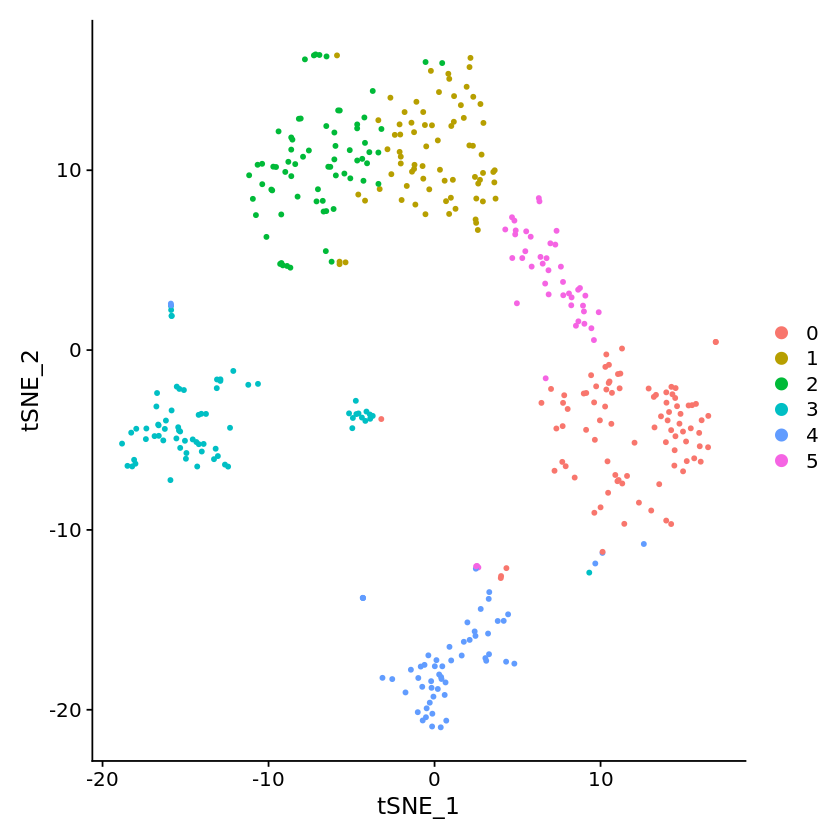

In [18]:
DimPlot(seurat)

In [10]:
#seurat[['tsne']]
#reducedDim(seurat, 'tsne')
Embeddings(seurat[['tsne']])

,tSNE_1,tSNE_2
A10.MAA000595.3_9_M.1.1,-14.9469307,-5.725040
A17.B002431.3_39_F.1.1,-0.1477169,-20.929645
A17.MAA000594.3_8_M.1.1,-12.4363319,-6.479416
A17.MAA000906.3_11_M.1.1,-9.2337706,7.539953
A17.MAA000908.3_10_M.1.1,-7.9225295,10.749217
A18.B002431.3_39_F.1.1,2.6392591,-12.085822
A18.MAA000908.3_10_M.1.1,7.3488327,6.630922
A19.MAA000595.3_9_M.1.1,7.6940273,-6.217182
A20.B002431.3_39_F.1.1,0.1952821,-18.844233
A20.MAA000594.3_8_M.1.1,7.7165196,-4.229133


In [3]:
load()

In [112]:
file_name=file_name_all[9]
file_name

[[1]]
[1] "facs_Large_Intestine_seurat_tiss.Robj"

In [115]:
ls()

[1] "file_name"       "file_name_all"   "filter_exp"      "path"           
[5] "save_hvg_seurat" "save_sce"        "tiss"            "tiss_new"

Updating from v2.X to v3.X

Validating object structure

Updating object slots

Ensuring keys are in the proper strucutre

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



In [121]:
seurat

An object of class Seurat 
23341 features across 3938 samples within 1 assay 
Active assay: RNA (23341 features, 5674 variable features)
 2 dimensional reductions calculated: pca, tsne

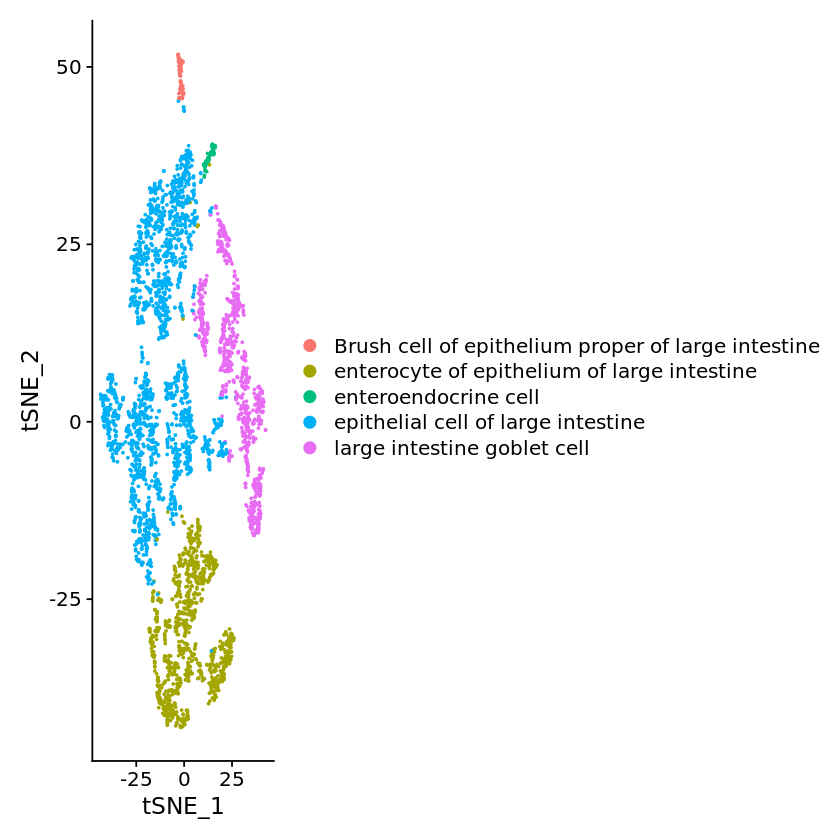

In [122]:
DimPlot(seurat,group.by='cell_ontology_class')

Centering and scaling data matrix

PC_ 1 
Positive:  Agr2, Cd24a, Tspan13, Pdia6, Txndc5, Atp6ap2, Chst4, Pdia5, Slc50a1, Herpud1 
	   Dpysl2, Ly6e, Cd81, St3gal6, Creb3l4, Qsox1, Klk1, Nr4a1, Ssr1, Oit1 
	   Hepacam2, Atp2c2, Hspa5, Ramp1, Slc12a8, Anxa5, Ern2, Rab15, Bace2, Pim3 
Negative:  Cyp2c55, Krt20, 1810065E05Rik, Prss30, Sectm1b, Emp1, Car1, Ces2e, Ces2c, Car4 
	   Ces2a, Mep1a, Cyp3a13, Dpep1, Cdhr2, Tmigd1, Ceacam20, Mxd1, 1110032A04Rik, Slc26a3 
	   Pmp22, Lgals3, Mgat4c, Slc9a2, Mettl7b, Fmo5, Slc13a2, 2610528A11Rik, Fabp2, Aqp8 
PC_ 2 
Positive:  Ramp1, Gm1123, Hpd, Tpsg1, Ccl6, Hgfac, Hepacam2, Spink4, Atp2c2, Spdef 
	   Rep15, Lrrc26, Qsox1, Slc12a8, Gde1, Bcas1, Cgref1, Sval1, Bace2, Rap1gap 
	   Atoh1, Gpr20, Nupr1, Creb3l4, 1810030J14Rik, Gsn, 1110003E01Rik, Tnfaip8, Tspan13, P2rx4 
Negative:  Mgst1, Stmn1, Sult1a1, Hmgb2, Ccna2, 2810417H13Rik, Birc5, Tubb5, Racgap1, Tmpo 
	   Otc, Pbk, Cdk1, Cdca8, Shmt1, Cdca3, Spc24, Ube2c, Hmgn2, Tk1 
	   Top2a, Hmgcs2, Isyna1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3938
Number of edges: 148254

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7965
Number of communities: 25
Elapsed time: 0 seconds


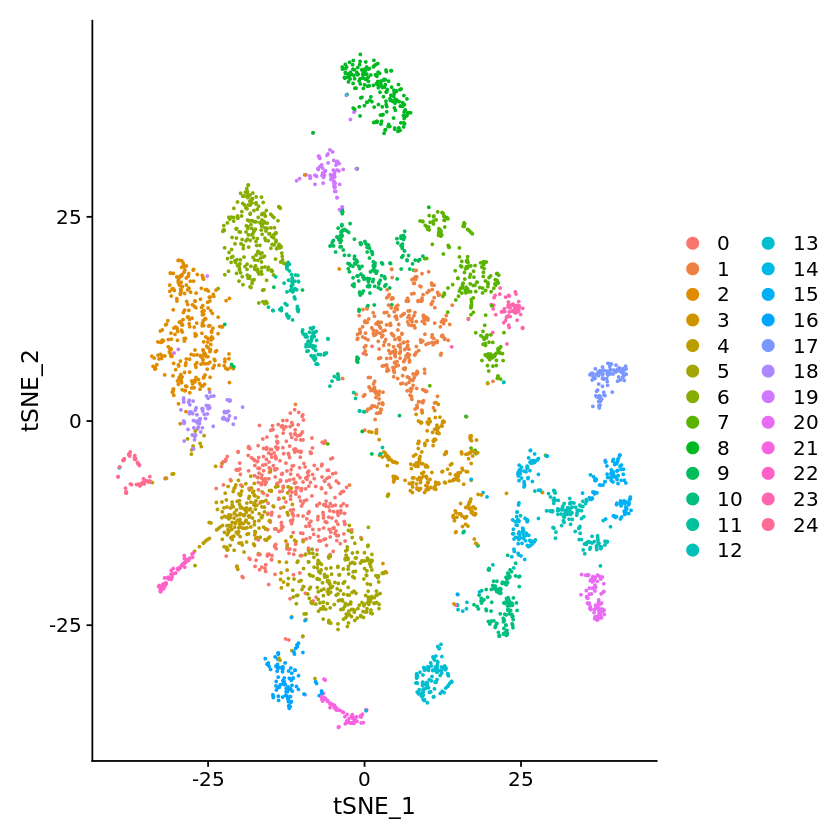

In [134]:
DimPlot(seurat_hvg_pca_label_cluster,group.by='seurat_clusters')

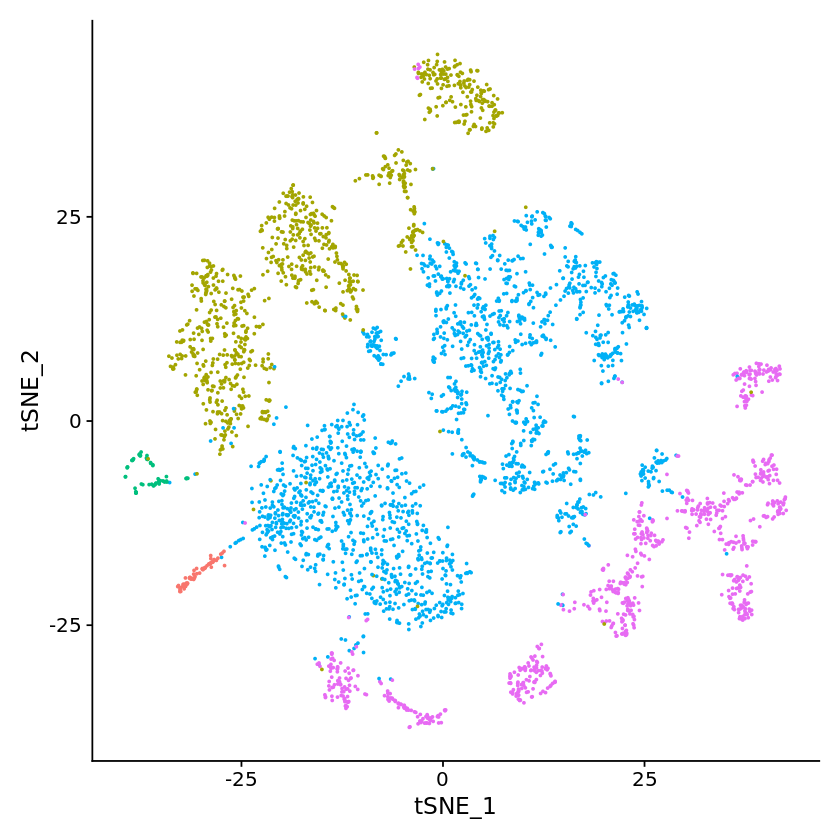

In [139]:
DimPlot(seurat_hvg_pca_label_cluster,group.by='phenoid')+ NoLegend()

In [119]:
tiss_new@meta.data

,nReads,orig.ident,plate.barcode,mouse.id,tissue,subtissue,FACS.selection,mouse.sex,percent.ercc,free_annotation,cell_ontology_class,percent.ribo,res.0.7,cluster.ids,cell_ontology_id,nCount_RNA,nFeature_RNA
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
A1.MAA000611.3_8_M.1.1,1107042,Large_Intestine,MAA000611,3_8_M,Large_Intestine,Proximal,Multiple,M,0.009895305,Lgr5+ undifferentiated cell (Proximal),epithelial cell of large intestine,0.045037135,1,1,CL:0002253,1107042,4635
A1.MAA000612.3_9_M.1.1,328769,Large_Intestine,MAA000612,3_9_M,Large_Intestine,Proximal,Multiple,M,0.024464859,Lgr5- undifferentiated cell,epithelial cell of large intestine,0.013507965,4,4,CL:0002253,328769,1308
A1.MAA000870.3_10_M.1.1,1957713,Large_Intestine,MAA000870,3_10_M,Large_Intestine,Distal,Multiple,M,0.002745653,Goblet cell (Distal),large intestine goblet cell,0.024274753,6,6,CL:1000320,1957713,6376
A1.MAA000871.3_11_M.1.1,515953,Large_Intestine,MAA000871,3_11_M,Large_Intestine,Proximal,Multiple,M,0.036693017,Lgr5- undifferentiated cell,epithelial cell of large intestine,0.009403957,4,4,CL:0002253,515953,1357
A1.MAA000909.3_10_M.1.1,431942,Large_Intestine,MAA000909,3_10_M,Large_Intestine,Proximal,Multiple,M,0.007839579,Goblet cell (Proximal),large intestine goblet cell,0.017694505,11,11,CL:1000320,431942,3748
A1.MAA000937.3_8_M.1.1,355303,Large_Intestine,MAA000937,3_8_M,Large_Intestine,Distal,Multiple,M,0.003662274,Goblet cell (Distal),large intestine goblet cell,0.036793948,6,6,CL:1000320,355303,5988
A1.MAA001632.3_56_F.1.1,622072,Large_Intestine,MAA001632,3_56_F,Large_Intestine,Proximal,Multiple,F,0.015718205,Goblet cell (Proximal),large intestine goblet cell,0.020944521,11,11,CL:1000320,622072,4199
A1.MAA001869.3_38_F.1.1,665959,Large_Intestine,MAA001869,3_38_F,Large_Intestine,Proximal,Multiple,F,0.064975563,Lgr5- amplifying undifferentiated cell,epithelial cell of large intestine,0.087281649,0,0,CL:0002253,665959,1977
A1.MAA001871.3_39_F.1.1,185427,Large_Intestine,MAA001871,3_39_F,Large_Intestine,Proximal,Multiple,F,0.050849453,Lgr5- undifferentiated cell,epithelial cell of large intestine,0.049043559,4,4,CL:0002253,185427,1275


In [ ]:
path=

,nReads,orig.ident,plate.barcode,mouse.id,tissue,subtissue,FACS.selection,mouse.sex,percent.ercc,free_annotation,cell_ontology_class,percent.ribo,res.0.4,cluster.ids,cell_ontology_id,nCount_RNA,nFeature_RNA
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>
A1.B000610.3_56_F.1.1,610727,Bladder,B000610,3_56_F,Bladder,,Multiple,F,0.024547354,Bladder mesenchymal cell,bladder cell,0.036029191,5,5,CL:1001319,610727,2569
A1.B002764.3_38_F.1.1,320035,Bladder,B002764,3_38_F,Bladder,,Multiple,F,0.428984095,Luminal bladder epithelial cell,bladder urothelial cell,0.002490353,3,3,CL:1001428,320035,578
A1.B002771.3_39_F.1.1,1044981,Bladder,B002771,3_39_F,Bladder,,Multiple,F,0.011236157,Bladder mesenchymal cell,bladder cell,0.018430957,5,5,CL:1001319,1044981,3998
A1.D041914.3_8_M.1.1,447232,Bladder,D041914,3_8_M,Bladder,,Multiple,M,0.020742054,Bladder mesenchymal cell,bladder cell,0.047554737,5,5,CL:1001319,447232,3401
A1.D042253.3_9_M.1.1,330249,Bladder,D042253,3_9_M,Bladder,,Multiple,M,0.008159992,Bladder mesenchymal cell,bladder cell,0.013950080,2,2,CL:1001319,330249,4439
A1.MAA000487.3_10_M.1.1,748761,Bladder,MAA000487,3_10_M,Bladder,,Multiple,M,0.008691611,Bladder mesenchymal cell,bladder cell,0.024045056,0,0,CL:1001319,748761,4471
A10.B000610.3_56_F.1.1,1486054,Bladder,B000610,3_56_F,Bladder,,Multiple,F,0.008497521,Luminal bladder epithelial cell,bladder urothelial cell,0.054947532,3,3,CL:1001428,1486054,4182
A10.B002764.3_38_F.1.1,3783292,Bladder,B002764,3_38_F,Bladder,,Multiple,F,0.006412256,Luminal bladder epithelial cell,bladder urothelial cell,0.057898782,3,3,CL:1001428,3783292,3553
A10.B002771.3_39_F.1.1,947995,Bladder,B002771,3_39_F,Bladder,,Multiple,F,0.013280195,Luminal bladder epithelial cell,bladder urothelial cell,0.060643780,3,3,CL:1001428,947995,3634


In [23]:
adjustedRandIndex(tiss_new@meta.data['res.1.5'],tiss_new@meta.data['cell_ontology_class'])

[1] 1

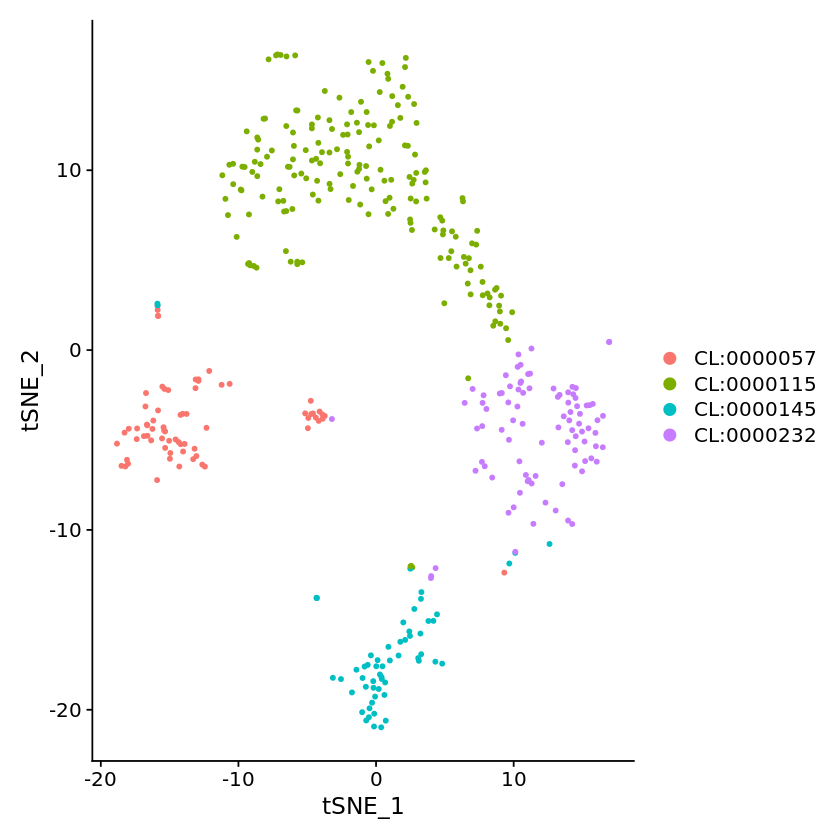

In [20]:
DimPlot(tiss_new,group.by='cell_ontology_id')

[1] 1

In [13]:
slotNames(tiss_new[['RNA']])

[1] "counts"        "data"          "scale.data"    "key"          
[5] "assay.orig"    "var.features"  "meta.features" "misc"

In [15]:
tiss_new[['RNA']]@counts

   [[ suppressing 32 column names ‘A10.MAA000595.3_9_M.1.1’, ‘A17.B002431.3_39_F.1.1’, ‘A17.MAA000594.3_8_M.1.1’ ... ]]

   [[ suppressing 32 column names ‘A10.MAA000595.3_9_M.1.1’, ‘A17.B002431.3_39_F.1.1’, ‘A17.MAA000594.3_8_M.1.1’ ... ]]

   [[ suppressing 32 column names ‘A10.MAA000595.3_9_M.1.1’, ‘A17.B002431.3_39_F.1.1’, ‘A17.MAA000594.3_8_M.1.1’ ... ]]



23341 x 408 sparse Matrix of class "dgCMatrix"
                                                                                            
0610005C13Rik    .    .   .   .    .    .    .   .    .   .   .    .    .    .   .    .    1
0610007C21Rik  313    .   .   .    .    .  508   .   76   .  87  215   10  406   .  183    .
0610007L01Rik    .    . 157   .    .    .  141   .    .   .  36    .    .  714   .    .    .
0610007N19Rik  138    . 134   .    .    .    .   .    .   .   .    .    .    .   .    .    .
0610007P08Rik    .   81   .   .    .    .    .   .    .   .   .    5    .  358   .    .    .
0610007P14Rik    .  282   .   .    .    .    .   .    8   .   .  146    .    .   .    .    .
0610007P22Rik    .    .   .   .   24    .    .   .  441   .   .    .    .    .   .    .    .
0610008F07Rik    .    .   .   .    .    .    .   .    .   .   .    .    .    .   .    .    .
0610009B14Rik    .    .   .   .    .    .    .   .    .   .   .    .    .    .   .    .    .
0610009B22Rik    .    .